In [1]:
import numpy as np
import sympy, scipy, cmath
from sympy import *
#from sympy import symbols
#from sympy.solvers.solveset import nonlinsolve
from scipy import sparse as sp
#from scipy import linalg as ln
from scipy import optimize as opt
from scipy.sparse import  coo_matrix as cmm
from matplotlib import pyplot as pp

In [109]:
#Parameters
#default values: mu=1.8 m=.5 t=3 alR=.7 B=3.07 delta=.5 phi=Pi

kx=0.

mu=1.8
muSC=1.8
m=.5
t=3.
alR=0.
B=3.07
delta=.5
phi=np.pi*1.75

def mut(kx):
    return mu-2*t-kx**2/(2*m)-alR**2*m/2
def kF(mu):
    return cmath.sqrt(2*m*mu)
def a(t):
    return 1/cmath.sqrt(2*m*t)

def delL(phi):
    return delta*cmath.exp(1j*phi/2)
def delR(phi):
    return delta*cmath.exp(-1j*phi/2)
def nu0(m):
    return m/(2*np.pi)
def xiE(En):
    return kF(mu)/(m*cmath.sqrt(delta**2-En**2))

tL=2.
tR=tL

NJ=15
gamma=np.pi*nu0(m)*tL**2

#matrix tools
eye2=np.eye(2)
eye4=np.eye(4)
s1=[[0,1],[1,0]]
s2=[[0,-1j],[1j,0]]
s3=[[1,0],[0,-1]]
tP=np.kron([[0,1],[0,0]],eye2)
tM=np.kron([[0,0],[1,0]],eye2)
t3=np.kron(s3,eye2)

In [110]:
#Junction
def HJ0(kx,B):
    return -mut(kx)*t3+alR*kx*np.kron(s3,s2)+B*np.kron(eye2,s1)
def Hy(alR):
    return -t*t3+1j*alR/2/a(t)*np.kron(s3,s1)


def HJ(kx,B):
    start=cmm(HJ0(kx,B))
    HJs=start
    for n in range(0,NJ-1):
        OT=cmm(np.zeros([len(HJs.toarray())-4,4]))
        BT=sp.vstack([OT,cmm(Hy(alR))])
        CT=sp.hstack([OT.transpose(),cmm(Hy(alR).conj().T),start])
        HJs=sp.hstack([HJs,BT])
        HJs=sp.vstack([HJs,CT])
    return HJs

def gJm1(En,kx,B):
    return En*np.eye(4*NJ)-HJ(kx,B).toarray()

#Superconductors
# xiE-> infty to avoid more symbolic:
#def fL(kx):
#    return 1/(kF*a)*(np.log(1-np.exp(1j*a*(kF+kx)))+np.log(1-np.exp(1j*a*(kF-kx))))-1j

def fL(En,kx):
    return 1/(kF(muSC)*a(t))*(cmath.log(1-cmath.exp(-a(t)/xiE(En)+1j*a(t)*(kF(mu)+kx)))+\
                         cmath.log(1-cmath.exp(-a(t)/xiE(En)+1j*a(t)*(kF(muSC)-kx))))-1j

def gSC1m1(En,kx,phi):
    return -1/(np.pi*nu0(m)*abs(fL(En,kx))**2)*((En*eye4 - delL(phi)*tP - np.conj(delL(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

def gSC2m1(En,kx,phi):
    return -1/(np.pi*nu0(m)*abs(fL(En,kx))**2)*((En*eye4 - delR(phi)*tP - np.conj(delR(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

#SC/J coupling
rowindex=np.array([1,2,3,4,4*NJ+1,4*NJ+2,4*NJ+3,4*NJ+4])-1
colindex=np.array([5,6,7,8,4*(NJ+1)+1,4*(NJ+1)+2,4*(NJ+1)+3,4*(NJ+1)+4])-1
hoppings=[tL,tL,-tL,-tL,tR,tR,-tR,-tR]
mHt1=cmm((hoppings,(rowindex,colindex)),shape=(4*(NJ+2),4*(NJ+2)))
mHt=mHt1+mHt1.transpose()

#total inverse GF
def Gtotm1(En,kx,phi,B):
    return scipy.linalg.block_diag(gSC1m1(En,kx,phi),gJm1(En,kx,B),gSC2m1(En,kx,phi))+mHt.toarray()

In [112]:
M=50
phiarray=np.linspace(0,2*np.pi,M+1)
#Barray1=np.ndarray.tolist(np.linspace(3.2,3.https://www.youtube.com/?hl=FR3,20))
#Barray2=np.ndarray.tolist(np.linspace(9.15,9.45,40))
#Barray3=np.ndarray.tolist(np.linspace(2.9,3.1,30))
#Barray=[1]#np.asarray(Barray1+Barray2)#+Barray3)
#M=len(Barray)-1

PDB=np.zeros((M+1,NJ))#2*NJ))

En=0

for qq in range(M+1):
    phi=phiarray[qq]
    print(qq)
    ekxphi=[]
    def fdetB(B):
        return np.linalg.det(Gtotm1(En,kx,phi,B))/(mu**((2*t+mu)*(NJ+2)))
    x0roots=np.ndarray.tolist(np.linspace(0,12,20))
    for i in range(len(x0roots)):
        x0=x0roots[i]
        solekx=opt.fsolve(fdetB,np.asarray(x0))
        if abs(fdetB(solekx))>10**-6 or solekx<0:# or solekx>2*np.pi+0.1
            solekx=[]
        solekx=np.ndarray.tolist(np.around(solekx,10))
        ekxphi.extend(solekx)
    ekxphi=sorted(list(set(ekxphi)))
    print(ekxphi)
    if len(ekxphi)<NJ: ###here 2*
        zerocompletion=[0]*(NJ-len(ekxphi)) ###here
        ekxphi.extend(zerocompletion)
    elif len(ekxphi)>NJ:  ###here
        print("Too many roots.")
        break
    PDB[qq]=np.asarray(ekxphi)

0
[0.537690611, 1.2551101709, 1.6872857247, 2.3335050975, 3.3975162191, 4.4984998974, 5.5945380004, 6.6505202724, 7.6305726232, 8.4976858316, 9.2160265559, 10.0871865316]
1


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in cdouble_scalars


[0.5388399785, 1.2531128325, 1.6871744458, 2.3335098501, 3.3975160941, 4.498499906, 5.5945379995, 6.6505202725, 7.6305726232, 8.4976858316, 9.2160265559, 10.0871865316]
2
[0.5421927351, 1.2477795244, 1.686841447, 2.3335240316, 3.3975157211, 4.4984999318, 5.5945379966, 6.650520273, 7.6305726231, 8.4976858316, 9.2160265559, 10.0871865316]
3
[0.5474953884, 1.2403201065, 1.6862892552, 2.3335474149, 3.3975151058, 4.4984999743, 5.594537992, 6.6505202736, 7.630572623, 8.4976858317, 9.2160265559, 10.0871865316]
4
[0.5544106799, 1.2316404173, 1.6855221218, 2.3335796255, 3.3975142581, 4.4985000328, 5.5945379855, 6.6505202746, 7.6305726228, 8.4976858317, 9.2160265559, 10.0871865316]
5
[0.5625898145, 1.2222642829, 1.6845460846, 2.3336201479, 3.3975131913, 4.4985001066, 5.5945379774, 6.6505202758, 7.6305726226, 8.4976858318, 9.2160265558, 10.0871865316]
6
[0.5717168576, 1.2124861745, 1.6833690548, 2.3336683341, 3.3975119222, 4.4985001942, 5.5945379678, 6.6505202772, 7.6305726223, 8.4976858318, 9.21

[0.537690611, 1.2551101709, 1.6872857247, 2.3335050975, 3.3975162191, 4.4984998974, 5.5945380004, 6.6505202724, 7.6305726232, 8.4976858316, 9.2160265559, 10.0871865316]


PDBa4=PDB
Php4=phiarray

[2.3, 2.35, 0, 6.3]

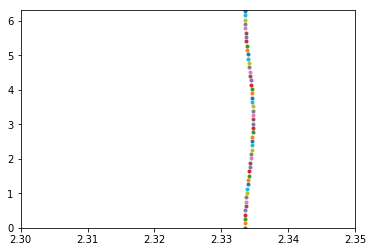

In [118]:
for p in range(len(PDBa4)):
    pp.plot(PDBa4[p],[Php4[p]]*(NJ),'.')
pp.axis([2.3,2.35,0,6.3])

PDBa3=PDB
Php3=phiarray

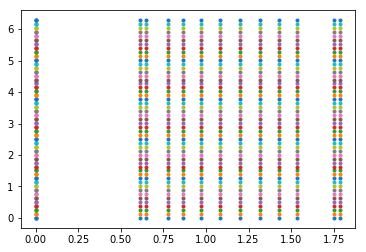

In [88]:
for p in range(len(PDBa3)):
    pp.plot(PDBa3[p],[Php3[p]]*(NJ),'.')

PDBa2=PDB
Php2=phiarray

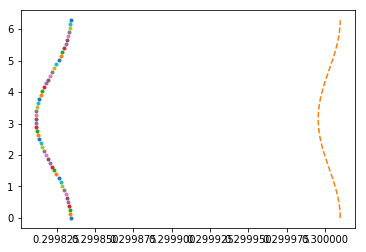

In [58]:
for p in range(len(PDB)):
    pp.plot(PDBa2[p][0],[Php2[p]]*(NJ-1),'.')
phiphi=np.linspace(0,2*np.pi,100)
Barray=[np.sqrt(mut(0)**2+t**2+gamma**2+t*np.sqrt(4*mut(0)**2+2*gamma**2*(1-np.cos(ph)))) for ph in phiphi]
Barray2=[np.sqrt(mut(0)**2+t**2+gamma**2-t*np.sqrt(4*mut(0)**2+tL**6+2*gamma**2*(1-np.cos(ph)))) for ph in phiphi]
#pp.plot(Barray,phiphi,'--')
pp.plot(Barray2,phiphi,'--')

PDBa1=PDB
Php1=phiarray

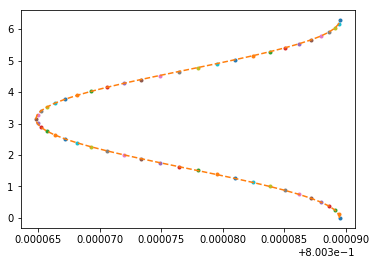

In [63]:
for p in range(len(PDB)):
    pp.plot(PDBa1[p],[Php1[p]]*(NJ),'.')
phiphi=np.linspace(0,2*np.pi,51)
Barray=[np.sqrt(mut(0)**2+2*gamma**2*(np.abs(fL(0,0))**2+fL(0,0).imag**2*np.cos(ph))-4*gamma*mut(0)*fL(0,0).real) for ph in phiphi]
pp.plot(Barray,phiphi,'--')

In [127]:
B=2.00585
ppk=np.arange(1000)*2*np.pi/1000
detppk=[np.linalg.det(Gtotm1(0,0,ppk[j]))/(mu**(4*(NJ+0))) for j in range(len(ppk))]
ppk[np.argmin(detppk)]

5.548052626239574

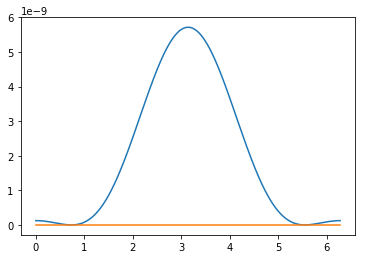

In [120]:
pp.plot(ppk,detppk)
pp.plot(ppk,np.zeros(len(ppk)))
#pp.axis([0,2*np.pi,0,10**-11])

In [129]:
uhgf=ppk[np.argmin(detppk)]
zer=(-uhgf)%(2*np.pi)

In [130]:
print(uhgf,zer)

(5.548052626239574, 0.735132680940012)


Text(0.5,1,'Topological phase diagram')

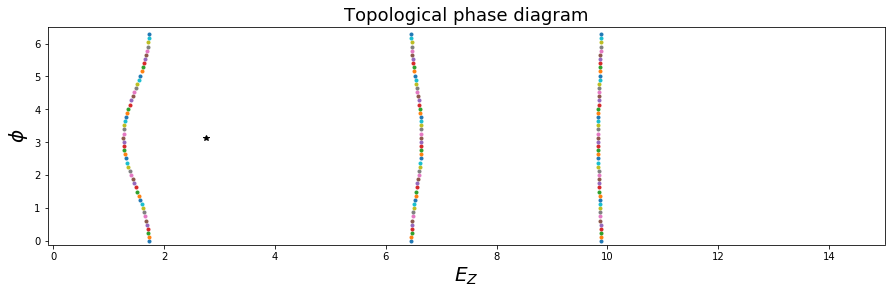

In [116]:
pp.figure(figsize=(15,4))
for p in range(len(PDB)):
    pp.plot(PDB[p],[phiarray[p]]*(NJ),'.')
pp.plot(2.75,np.pi,'k*')
#pp.plot(9.26,np.pi,'*')
pp.axis([-0.1,15,-0.1,6.5])
pp.xlabel('$E_Z$',fontsize=20)
pp.ylabel('$\phi$',fontsize=20)
pp.title('Topological phase diagram',fontsize=18)

In [76]:
def adjMat(matr,row,col):
    # matr    should be an array, not a list
    #returns an array
    adj=np.ndarray.tolist(matr)
    adj[row:row+1]=[]
    for i in range(len(adj)):
        adj[i][col:col+1]=[]
    return np.asarray(adj)

In [77]:
A=np.around(Gtotm1(0,0,3.14,3),2)
print('\n'.join([''.join(['{:4}'.format(item) for item in row]) 
      for row in A]))

(-0.18+0j)  0j(-0-3.17j)  0j(0.1+0j)  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j
  0j(-0.18+0j)  0j(-0-3.17j)  0j(0.1+0j)  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j
(-0+3.17j)  0j(0.18+0j)  0j  0j  0j(-0.1+0j)  0j  0j  0j  0j  0j  0j  0j  0j  0j
  0j(-0+3.17j)  0j(0.18+0j)  0j  0j  0j(-0.1+0j)  0j  0j  0j  0j  0j  0j  0j  0j
(0.1+0j)  0j  0j  0j(0.8+0j)(-3+0j)  0j  0j(1.1+0j)  0j  0j  0j  0j  0j  0j  0j
  0j(0.1+0j)  0j  0j(-3+0j)(0.8+0j)  0j  0j  0j(1.1+0j)  0j  0j  0j  0j  0j  0j
  0j  0j(-0.1+0j)  0j  0j  0j(-0.8+0j)(-3+0j)  0j  0j(-1.1+0j)  0j  0j  0j  0j  0j
  0j  0j  0j(-0.1+0j)  0j  0j(-3+0j)(-0.8+0j)  0j  0j  0j(-1.1+0j)  0j  0j  0j  0j
  0j  0j  0j  0j(1.1+0j)  0j  0j  0j(0.8+0j)(-3+0j)  0j  0j(0.1+0j)  0j  0j  0j
  0j  0j  0j  0j  0j(1.1+0j)  0j  0j(-3+0j)(0.8+0j)  0j  0j  0j(0.1+0j)  0j  0j
  0j  0j  0j  0j  0j  0j(-1.1+0j)  0j  0j  0j(-0.8+0j)(-3+0j)  0j  0j(-0.1+0j)  0j
  0j  0j  0j  0j  0j  0j  0j(-1.1+0j)  0j  0j(-3+0j)(-0.8+0j)  0j  0j  0j(-0.1+0j)
  0j  0j  0j  0j  0j  0j

In [78]:
Acut=adjMat(A,2,3)
print('\n'.join([''.join(['{:4}'.format(item) for item in row]) 
      for row in Acut]))

(-0.18+0j)  0j(-0-3.17j)(0.1+0j)  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j
  0j(-0.18+0j)  0j  0j(0.1+0j)  0j  0j  0j  0j  0j  0j  0j  0j  0j  0j
  0j(-0+3.17j)  0j  0j  0j  0j(-0.1+0j)  0j  0j  0j  0j  0j  0j  0j  0j
(0.1+0j)  0j  0j(0.8+0j)(-3+0j)  0j  0j(1.1+0j)  0j  0j  0j  0j  0j  0j  0j
  0j(0.1+0j)  0j(-3+0j)(0.8+0j)  0j  0j  0j(1.1+0j)  0j  0j  0j  0j  0j  0j
  0j  0j(-0.1+0j)  0j  0j(-0.8+0j)(-3+0j)  0j  0j(-1.1+0j)  0j  0j  0j  0j  0j
  0j  0j  0j  0j  0j(-3+0j)(-0.8+0j)  0j  0j  0j(-1.1+0j)  0j  0j  0j  0j
  0j  0j  0j(1.1+0j)  0j  0j  0j(0.8+0j)(-3+0j)  0j  0j(0.1+0j)  0j  0j  0j
  0j  0j  0j  0j(1.1+0j)  0j  0j(-3+0j)(0.8+0j)  0j  0j  0j(0.1+0j)  0j  0j
  0j  0j  0j  0j  0j(-1.1+0j)  0j  0j  0j(-0.8+0j)(-3+0j)  0j  0j(-0.1+0j)  0j
  0j  0j  0j  0j  0j  0j(-1.1+0j)  0j  0j(-3+0j)(-0.8+0j)  0j  0j  0j(-0.1+0j)
  0j  0j  0j  0j  0j  0j  0j(0.1+0j)  0j  0j  0j(-0.18+0j)  0j(-0+3.17j)  0j
  0j  0j  0j  0j  0j  0j  0j  0j(0.1+0j)  0j  0j  0j(-0.18+0j)  0j(-0+3.17j)
  0j  0j  0